## Fish weight prediction

*The analysis objective is to predict different types of fish species weight, given their proportions.* 

**Importing modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats # QQ plot
from sklearn.preprocessing import OneHotEncoder # Dummy variable
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split # Set spliting
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import statsmodels.api as sm

 
sns.set()

%matplotlib inline

**Loading and getting to know the dataset**

In [2]:
dataset = pd.read_csv('Fish.csv')
dataset.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


- Weight: in grams
- Lenght1, Lenght2, Lenght3: Different proportions in cm.
- Height: in cm
- Width: in cm
- Species: The only categorical column.

In [3]:
dataset.rename(columns= {'Species': 'Species', 'Length1':'DimVer', 'Length2':'DimDiag', 'Length3':'DimLong'}, inplace=True)

In [4]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,159.0,398.326415,357.978317,0.0000,120.00000,273.0000,650.0000,1650.000
DimVer,159.0,26.247170,9.996441,7.5000,19.05000,25.2000,32.7000,59.000
DimDiag,159.0,28.415723,10.716328,8.4000,21.00000,27.3000,35.5000,63.400
DimLong,159.0,31.227044,11.610246,8.8000,23.15000,29.4000,39.6500,68.000
Height,159.0,8.970994,4.286208,1.7284,5.94480,7.7860,12.3659,18.957
Width,159.0,4.417486,1.685804,1.0476,3.38565,4.2485,5.5845,8.142


In [5]:
print(pd.isnull(dataset).sum()) # Is there any missing value?

Species    0
Weight     0
DimVer     0
DimDiag    0
DimLong    0
Height     0
Width      0
dtype: int64


There are no missing values in the set

**Species quantity**

In [6]:
dataset.groupby('Species').size() 

Species
Bream        35
Parkki       11
Perch        56
Pike         17
Roach        20
Smelt        14
Whitefish     6
dtype: int64

There are 7 species in the set: Bream has the most amount of subjects and Whitefish has the least.

In [7]:
species = dataset['Species'].value_counts()
species = pd.DataFrame(species) # Creating DF

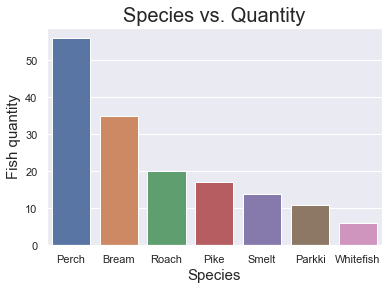

In [8]:
sns.barplot(x = species.index, y = species['Species'])
plt.title('Species vs. Quantity', fontsize = 20)
plt.xlabel('Species', fontsize = 15)
plt.ylabel('Fish quantity', fontsize = 15)
plt.show()

**Correlations between variables**

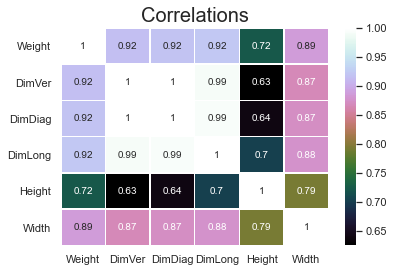

In [9]:
sns.heatmap(dataset.corr(), annot = True, linewidths=.5, cmap='cubehelix')
plt.title('Correlations', fontsize = 20)
plt.show()

- Weight is correlated to DimVer, DimDia, DimLong, Height and Width (> 0.7).
- DimVer and DimDiag are correlated with DimLong: **multicollinearity.**

**Plotting to see this last correlation between proportions.**

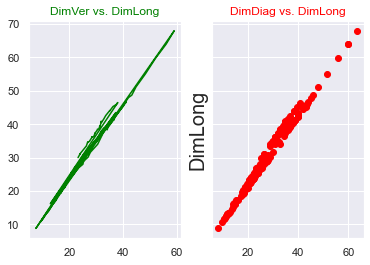

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

ax1.plot(dataset.DimVer, dataset.DimLong, c = 'green')
ax1.set_title('DimVer vs. DimLong', c = 'green')
ax2.scatter(dataset.DimDiag, dataset.DimLong, c='red')
ax2.set_title('DimDiag vs. DimLong', c ='red')

plt.ylabel('DimLong', fontsize = 20)

plt.show()

**Conclusión:** I will drop DimVer and DimDiag as they give the same amount of information that DimLong.

In [11]:
dataset_2 = dataset.copy() # Copying before dropping columns
dataset_2 = dataset_2.drop(['DimVer','DimDiag'], axis = 1) 

dataset_2 = dataset_2[['Species','DimLong','Height','Width','Weight']] # Rearrange columns.

dataset_2.head(3)

,Species,DimLong,Height,Width,Weight
0,Bream,30.0,11.5200,4.0200,242.0
1,Bream,31.2,12.4800,4.3056,290.0
2,Bream,31.1,12.3778,4.6961,340.0


**Are the independent variables Normally distributed? (this would improve the precision of a linear model)**

- Using Q-Q method, I'll generate a normally distributed set (ideal), and will compare it with mine.
- As the dataset is relatively small, there will be deviations to the normal distribution at the beginning and ending of the set.

*DimLong Variable*

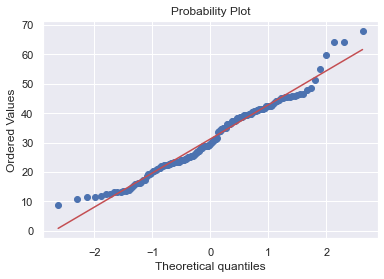

In [12]:
stats.probplot(dataset_2['DimLong'].values, dist="norm", plot=plt)
plt.show()

*Height Variable*

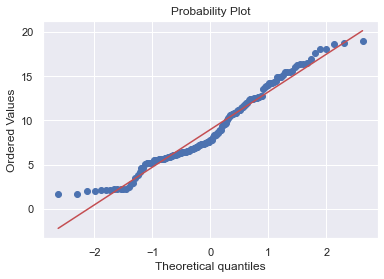

In [13]:
stats.probplot(dataset_2['Height'].values, dist="norm", plot=plt)
plt.show()

*Width Variable*

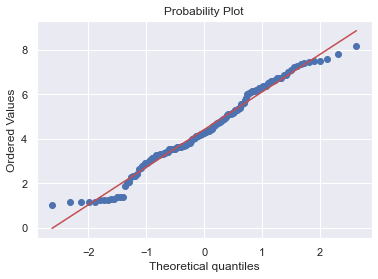

In [14]:
stats.probplot(dataset_2['Width'].values, dist="norm", plot=plt)
plt.show()

**Conclusion:** They are normally distributed (enough for a linear model to work).

**Outlier analysis**

IQR method

*DimLong variable*

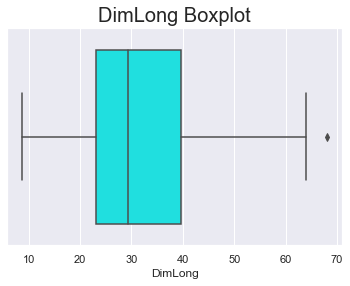

In [15]:
sns.boxplot(x=dataset_2['DimLong'], color = 'cyan')
plt.title('DimLong Boxplot', fontsize = 20)
plt.show()

There is an outlier, let's seek and destroy it.

In [16]:
DimLong= dataset_2['DimLong'] # Variable data
DimLong_Q1 = DimLong.quantile(0.25) # Q1 inf limit
DimLong_Q3 = DimLong.quantile(0.75) # Q3 sup limit
DimLong_IQR = DimLong_Q3 - DimLong_Q1 # IQR
DimLong_lowerend = DimLong_Q1 - (1.5 * DimLong_IQR) # q1 - 1.5 * q1
DimLong_upperend = DimLong_Q3 + (1.5 * DimLong_IQR) # q3 + 1.5 * q3

DimLong_outliers = DimLong[(DimLong < DimLong_lowerend) | (DimLong > DimLong_upperend)] # Outlier index
DimLong_outliers

144    68.0
Name: DimLong, dtype: float64

*Height Variable*

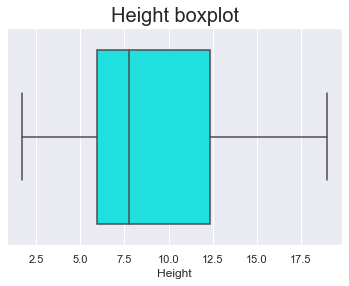

In [17]:
sns.boxplot(x=dataset_2['Height'], color = 'cyan')
plt.title('Height boxplot', fontsize = 20)
plt.show()

There are no outliers.

*Width variable*

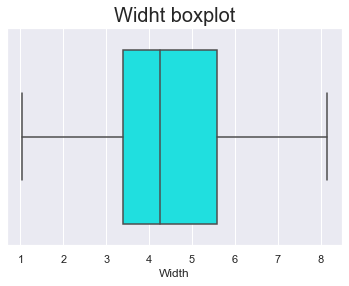

In [18]:
sns.boxplot(x=dataset_2['Width'], color = 'cyan')
plt.title('Widht boxplot', fontsize = 20)
plt.show()

There are no outliers.

*Weight Variable*

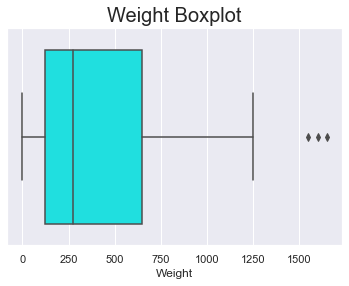

In [19]:
sns.boxplot(x=dataset_2['Weight'], color = 'cyan')
plt.title('Weight Boxplot', fontsize = 20)
plt.show()

*There are three outliers*

In [20]:
Peso = dataset_2['Weight'] 
Peso_Q1 = Peso.quantile(0.25) 
Peso_Q3 = Peso.quantile(0.75) 
Peso_IQR = Peso_Q3 - Peso_Q1 
Peso_lowerend = Peso_Q1 - (1.5 * Peso_IQR) 
Peso_upperend = Peso_Q3 + (1.5 * Peso_IQR) 

Peso_outliers = Peso[(Peso < Peso_lowerend) | (Peso > Peso_upperend)] # Outlier Index
Peso_outliers

142    1600.0
143    1550.0
144    1650.0
Name: Weight, dtype: float64

**Conclusion:** Drop subjetcs N°: 142,143 and 144

In [21]:
dataset_2 = dataset_2.drop([142,143,144], axis=0)
dataset_2.describe()

,DimLong,Height,Width,Weight
count,156.000000,156.000000,156.000000,156.000000
mean,30.571154,8.951128,4.375719,375.217308
std,10.695359,4.324325,1.672188,319.546978
min,8.800000,1.728400,1.047600,0.000000
25%,23.025000,5.931675,3.369600,120.000000
50%,29.250000,7.647800,4.243300,271.000000
75%,39.425000,12.378550,5.424375,612.500000
max,59.700000,18.957000,8.142000,1250.000000


**Let's visualize the tendency**

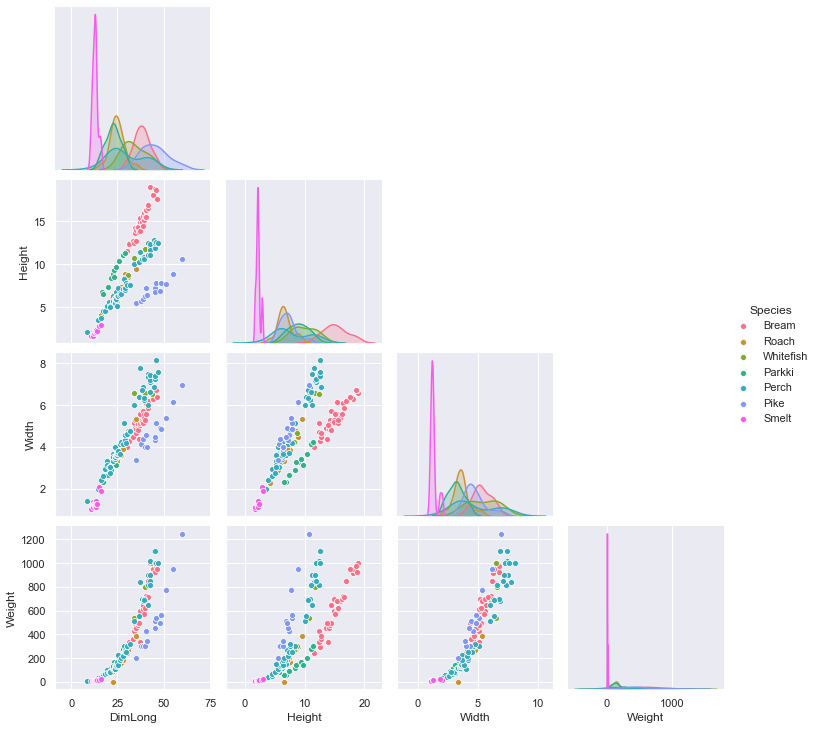

In [22]:
correlaciones = sns.pairplot(dataset_2, hue = "Species", palette = "husl", corner = True)

**Splitting variables**

In [23]:
X = dataset_2.iloc[:,0:4].values 

y = dataset_2.iloc[:,-1].values

**OHE**

In [24]:
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0])],   
    remainder='passthrough')
X = np.array(ct.fit_transform(X), dtype=np.float)
np.set_printoptions(suppress=True)

**Dropping one column of the dummy variable to avoid multicollinearity**

In [25]:
X = X[:,1:]
X.shape

(156, 9)

**Set splitting and Linear Regression model**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # Set Splitting

regression = LinearRegression() 
regression.fit(X_train, y_train)

LinearRegression()

**Predicting and visualizing**

In [27]:
y_pred = regression.predict(X_test) # Predictions

Prediccion_y = pd.DataFrame({'Prediction_y': y_pred})
Prediccion_y

Y = pd.DataFrame({'Y test': y_test}) # Df 
Comparacion = Y.join(Prediccion_y) 
Comparacion.head()

,Y test,Prediction_y
0,720.0,730.008963
1,390.0,513.484156
2,78.0,27.220220
3,685.0,756.073483
4,700.0,701.869372


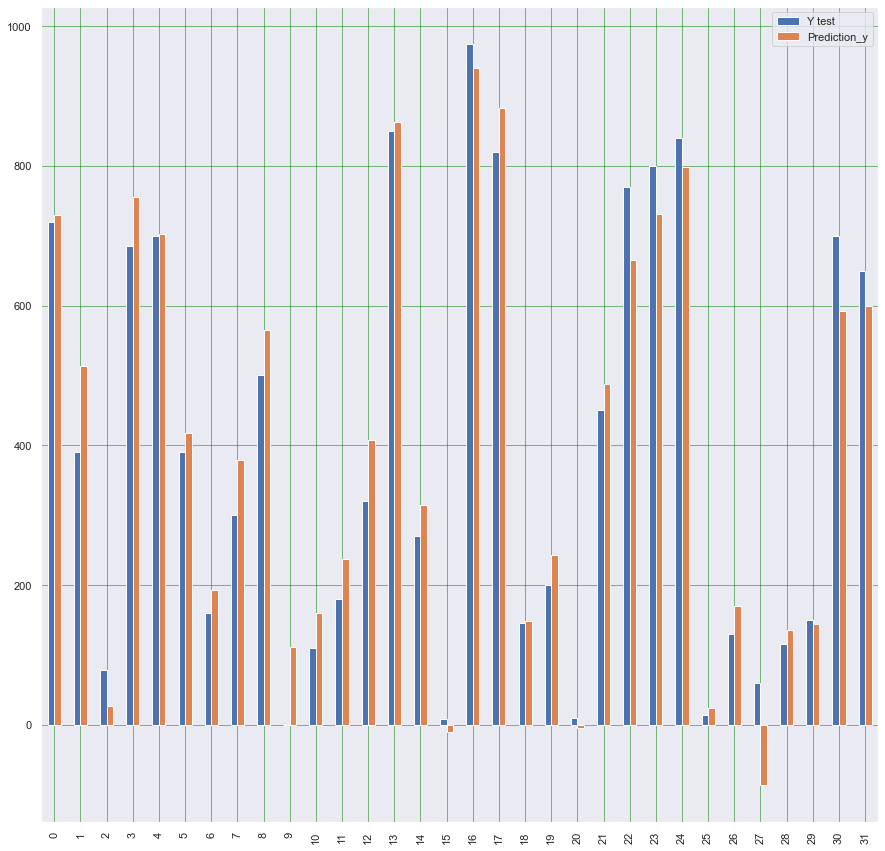

In [28]:
Comparacion.plot(kind = 'bar', figsize=(15,15))
plt.grid(which = 'both', linestyle = '-', linewidth = '0.5', color = 'green')
plt.show()

In [29]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))
Adj_r2 = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (156 - 1) / (156 - 9 - 1)
print('R2 adjusted', Adj_r2)

Mean Absolute Error: 51.13933609294101
Mean Squared Error: 3984.075147221337
Root Mean Squared Error: 63.11953063213744
R2: 0.9577158361694087
R2 adjusted 0.9551092781250572


**Conclusion:**  The model has a high score. However, we can see that some predicted values are far from accurate, given in some cases negative values. Let's see if we can improve this.

**Backward regression:** I will check if the amount of features used was right or there was any in excess.

-  I will add a one array to my independent variables to prepare the data.
- I will define a function where a feature will be dropped if the p-value is above the SL, but will also analyze if the R2 adjust value decreases or increases. This will keep the optimal number of features.s de R2 ajustado para quedarse con la mejor cantidad de variables independientes óptimas.
- As a previous analysis was made about correlation and multicolinearity there should be no changes in the amount of features.

In [30]:
# Adding np one array (intercept)

X = np.append(np.ones((dataset_2.shape[0],1)).astype(int), values = X  , axis = 1) 

def backwardElimination(x, SL):    
    numVars = len(x[0])    
    temp = np.zeros((X.shape[0], X.shape[1])).astype(int)   # Using X with the one array added. 
    for i in range(0, numVars):        # For loop for features
        regressor_OLS = sm.OLS(y, x.tolist()).fit()        
        maxVar = max(regressor_OLS.pvalues).astype(float)   # Max p-value for features
        adjR_before = regressor_OLS.rsquared_adj.astype(float)  # R2 adjusted value
        if maxVar > SL:            
            for j in range(0, numVars - i):  # Deleting feature if p-value > SL
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):                    
                    temp[:,j] = x[:, j]                    
                    x = np.delete(x, j, 1)                    
                    tmp_regressor = sm.OLS(y, x.tolist()).fit()                    
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)                    
                    if (adjR_before >= adjR_after):      # Takes into account having the best R2 adjusted                   
                        x_rollback = np.hstack((x, temp[:,[0,j]]))                        
                        x_rollback = np.delete(x_rollback, j, 1)     
                        print (regressor_OLS.summary())                        
                        return x_rollback                    
                    else:                        
                        continue    
    regressor_OLS.summary()    
    return x 
 
SL = 0.05
X_opt = X[:,:]
X_Modeled = backwardElimination(X_opt, SL)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     276.5
Date:                Sat, 22 Aug 2020   Prob (F-statistic):           5.03e-87
Time:                        20:07:37   Log-Likelihood:                -894.84
No. Observations:                 156   AIC:                             1810.
Df Residuals:                     146   BIC:                             1840.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -853.1347     68.280    -12.495      0.0

**Conclusión:** The chosen amount of features was the optimal in terms of R2 adjusted and p-values.

**Residual analysis**

In [31]:
residuals = Comparacion['Y test'] - Comparacion['Prediction_y']
temp = {'Residuals' : residuals, 'Predicted_y' : Comparacion['Prediction_y']}
residual_df = pd.DataFrame(temp)
residual_df.head()

,Residuals,Predicted_y
0,-10.008963,730.008963
1,-123.484156,513.484156
2,50.779780,27.220220
3,-71.073483,756.073483
4,-1.869372,701.869372


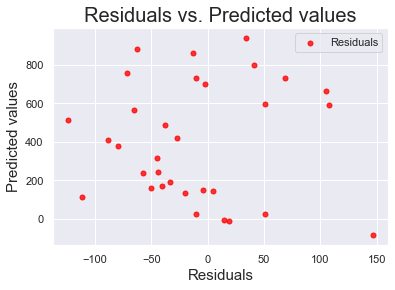

In [32]:
plt.scatter(residual_df['Residuals'], residual_df['Predicted_y'], c = 'red', s = 25, alpha = 0.8, label = 'Residuals')
plt.title('Residuals vs. Predicted values', fontsize = 20)
plt.xlabel('Residuals', fontsize = 15)
plt.legend()
plt.ylabel('Predicted values', fontsize = 15)
plt.show()

**Conclusion:**
- The residual distribution is random, so we can rule out autocorrelation and heteroscedasticity issues.

**Polynomial regression**

*Training*

In [33]:
poly_reg = PolynomialFeatures(degree = 2) # Degree depends on my set
X_poly = poly_reg.fit_transform(X_train) # Changing dependent features to polynomial

lin_reg_2 = LinearRegression() # Polynomial regression
lin_reg_2.fit(X_poly, y_train)

LinearRegression()

*Predictions*

In [34]:
X_test_poly = poly_reg.fit_transform(X_test)
y_pred_pol = lin_reg_2.predict(X_test_poly)

In [35]:
Prediccion_y = pd.DataFrame({'Prediction_y': y_pred_pol})

Y = pd.DataFrame({'Y test': y_test}) # Df 
Comparacion = Y.join(Prediccion_y) 
Comparacion.head()

,Y test,Prediction_y
0,720.0,716.421875
1,390.0,649.488281
2,78.0,-54.603516
3,685.0,771.201172
4,700.0,699.804688


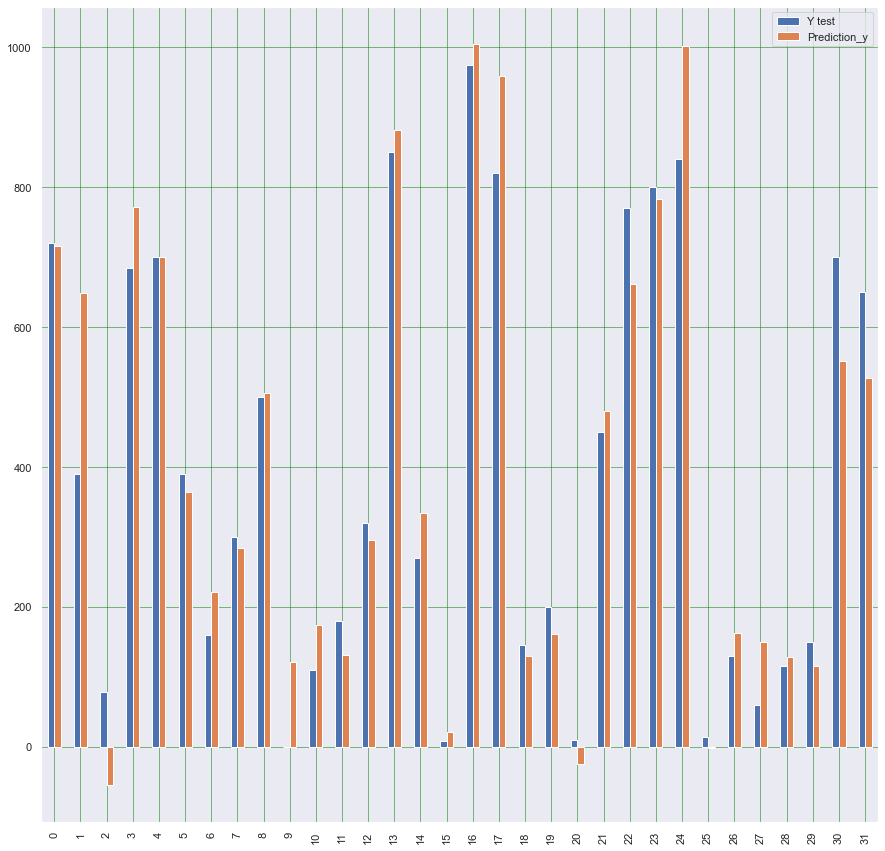

In [36]:
Comparacion.plot(kind = 'bar', figsize=(15,15))
plt.grid(which = 'both', linestyle = '-', linewidth = '0.5', color = 'green')
plt.show()

In [37]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_pol))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_pol))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_pol)))
print('R2:', metrics.r2_score(y_test, y_pred_pol))

Mean Absolute Error: 62.18052978515625
Mean Squared Error: 7313.121724123954
Root Mean Squared Error: 85.5167920593608
R2: 0.9223836836231407


**Conclusion:** Although the score value decreases, we can see less negative predictions. Let's see what happens with a more robust model.

**Random Forest Regressor**

In [38]:
RF_reg = RandomForestRegressor(n_estimators = 1000, random_state = 123)
RF_reg.fit(X_poly, y_train)

y_pred_rf = RF_reg.predict(X_test_poly)

In [39]:
Prediccion_y = pd.DataFrame({'Prediction_y': y_pred_rf})

Y = pd.DataFrame({'Y test': y_test}) # Df with real values and predicted values
Comparacion = Y.join(Prediccion_y) 
Comparacion.head()

,Y test,Prediction_y
0,720.0,710.8810
1,390.0,425.9990
2,78.0,82.2321
3,685.0,834.1600
4,700.0,655.3000


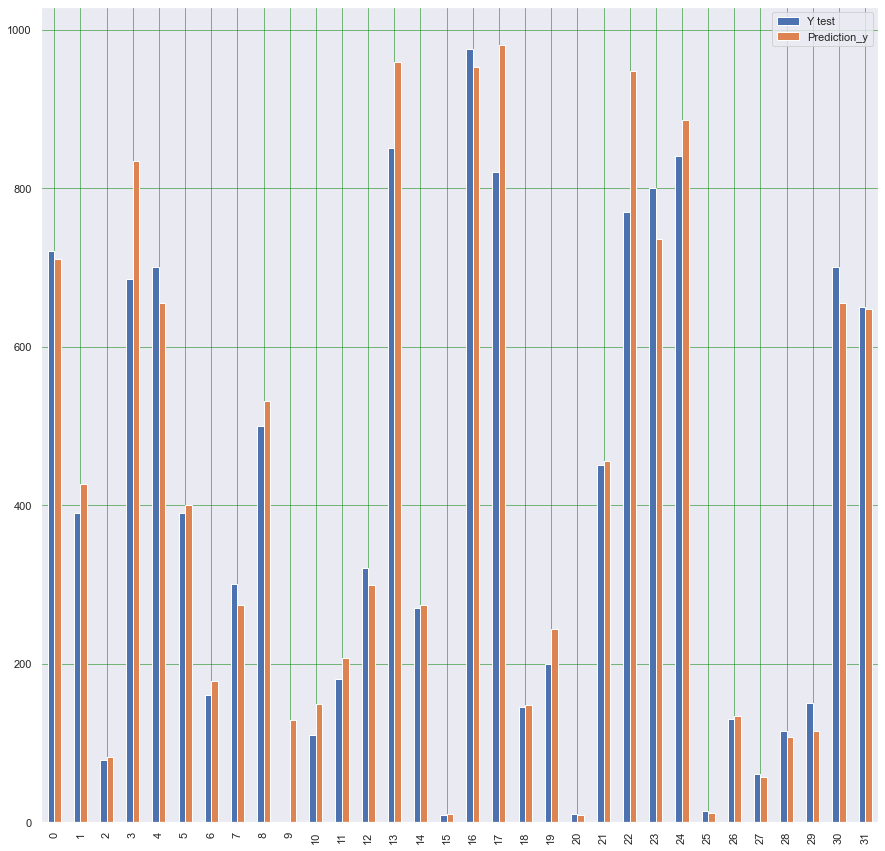

In [40]:
Comparacion.plot(kind = 'bar', figsize=(15,15))
plt.grid(which = 'both', linestyle = '-', linewidth = '0.5', color = 'green')
plt.show()

In [41]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print('R2:', metrics.r2_score(y_test, y_pred_rf))

Mean Absolute Error: 40.022521874999995
Mean Squared Error: 4009.284376293438
Root Mean Squared Error: 63.31891010032815
R2: 0.9574482831909286


**Conclusion:** We have reached the best model so far! The score is great and there are no negative predicions.